# YOLO CROP THE PERSONS FROM THE DATASET

In [ ]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO

def get_yolo_preds_and_save_crops(model, input_img_path, cropped_folder, no_person_folder, confidence_threshold=0.6):
    # Ensure output directories exist
    if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)

    if not os.path.exists(no_person_folder):
        os.makedirs(no_person_folder)


    # Read the input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return

    H, W = image.shape[:2]

    # Run YOLOv3 inference
    results = model.predict(input_img_path, device="cuda", conf=confidence_threshold)

    # Extract detected objects
    boxes = []
    confidences = []

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0].item())  # Get class ID
            confidence = box.conf[0].item()  # Confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            
                  # Ensure coordinates are within image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)
            
            if confidence > confidence_threshold and class_id == 0:  # Class ID 0 is "person"
                boxes.append([x1, y1, x2 - x1, y2 - y1])  # Convert to (x, y, w, h)
                confidences.append(confidence)

    # If no person detected, save original image
    if not boxes:
        no_person_filename = os.path.join(no_person_folder, os.path.basename(input_img_path))
        cv2.imwrite(no_person_filename, image)
        print(f"Saved image with no person detected: {no_person_filename}")
        return  

    # Save cropped persons
    for i, (x, y, w, h) in enumerate(boxes):
        cropped_person = image[y:y + h, x:x + w]

        if cropped_person.size == 0:
            print(f"Warning: Empty crop for {input_img_path} at box {boxes[i]}")
            continue

        original_filename = os.path.splitext(os.path.basename(input_img_path))[0]
        cropped_filename = os.path.join(cropped_folder, f"{original_filename}_person_{i + 1}_conf_{confidences[i]:.2f}.jpg")
        cv2.imwrite(cropped_filename, cropped_person)
        print(f"Saved cropped person: {cropped_filename}")

def process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.5):
    for label in ['Appropriate', 'Inappropriate']:  # Iterate over labeled folders
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)

        os.makedirs(output_label_folder, exist_ok=True)

        # Process each image in the folder
        for img_filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_filename)

            if os.path.isfile(img_path) and img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing image: {img_path}")
                get_yolo_preds_and_save_crops(model, img_path, output_label_folder, no_person_folder, confidence_threshold)

# Load Ultralytics YOLOv3 model with CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO("yolov3u.pt").to(device)

print(f"YOLO model is set to use: {device.upper()}")

# Example usage
input_folder = "./augmented_dataset"
output_folder = "./cropped_full"
no_person_folder = "./no_person_full"

process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.6)


# AUGMENTATION takes 4 mins only

In [ ]:
import os
import cv2

def augment_dataset(input_folder, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    for root, _, files in os.walk(input_folder):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, filename)

                # Load image
                image = cv2.imread(file_path)
                if image is None:
                    print(f"Error reading image {file_path}")
                    continue

                # Convert original to grayscale
                # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Flip the image horizontally
                flipped_image = cv2.flip(image, 1)

                # Save augmented images
                base_name, ext = os.path.splitext(filename)
                output_label_folder = os.path.join(output_folder, os.path.basename(root))
                os.makedirs(output_label_folder, exist_ok=True)

                # Paths for saving
                original_path = os.path.join(output_label_folder, f"{base_name}_original{ext}")
                # original_gray_path = os.path.join(output_label_folder, f"{base_name}_gray{ext}")
                flipped_color_path = os.path.join(output_label_folder, f"{base_name}_flipped{ext}")

                # Save the images
                cv2.imwrite(original_path, image)
                # cv2.imwrite(original_gray_path, gray_image)
                cv2.imwrite(flipped_color_path, flipped_image)

                print(f"Saved {original_path}, and {flipped_color_path}")

# Example usage
input_folder = "./Full Dataset"  # Path to your input dataset
output_folder = "./augmented_dataset"  # Path to save the augmented dataset

augment_dataset(input_folder, output_folder)


Saved ./augmented_dataset\Appropriate\00000001_original.jpg, ./augmented_dataset\Appropriate\00000001_gray.jpg, and ./augmented_dataset\Appropriate\00000001_flipped.jpg
Saved ./augmented_dataset\Appropriate\00000002_original.jpg, ./augmented_dataset\Appropriate\00000002_gray.jpg, and ./augmented_dataset\Appropriate\00000002_flipped.jpg
Saved ./augmented_dataset\Appropriate\0000000296_original.png, ./augmented_dataset\Appropriate\0000000296_gray.png, and ./augmented_dataset\Appropriate\0000000296_flipped.png
Saved ./augmented_dataset\Appropriate\00000003_original.jpg, ./augmented_dataset\Appropriate\00000003_gray.jpg, and ./augmented_dataset\Appropriate\00000003_flipped.jpg
Saved ./augmented_dataset\Appropriate\00000004_original.jpg, ./augmented_dataset\Appropriate\00000004_gray.jpg, and ./augmented_dataset\Appropriate\00000004_flipped.jpg
Saved ./augmented_dataset\Appropriate\00000006_original.png, ./augmented_dataset\Appropriate\00000006_gray.png, and ./augmented_dataset\Appropriate\0

# Augmentation takes 18 mins

In [8]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image

def augment_dataset_cuda(input_folder, output_folder, device='cuda'):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Define transformations
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()
    grayscale = transforms.Grayscale(num_output_channels=3)
    horizontal_flip = transforms.RandomHorizontalFlip(p=1.0)  # Always flip

    for root, _, files in os.walk(input_folder):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, filename)
                
                try:
                    # Load image and move it to the GPU
                    image = Image.open(file_path).convert('RGB')
                    image_tensor = to_tensor(image).to(device)

                    # Convert original to grayscale
                    gray_image_tensor = grayscale(image_tensor).to(device)
                    
                    # Flip the image horizontally
                    flipped_image_tensor = horizontal_flip(image_tensor).to(device)

                    # Convert tensors back to PIL images
                    original_image = to_pil(image_tensor.cpu())
                    gray_image = to_pil(gray_image_tensor.cpu())
                    flipped_image = to_pil(flipped_image_tensor.cpu())

                    # Prepare save paths
                    base_name, ext = os.path.splitext(filename)
                    output_label_folder = os.path.join(output_folder, os.path.basename(root))
                    os.makedirs(output_label_folder, exist_ok=True)

                    # Paths for saving
                    original_path = os.path.join(output_label_folder, f"{base_name}_original{ext}")
                    original_gray_path = os.path.join(output_label_folder, f"{base_name}_gray{ext}")
                    flipped_color_path = os.path.join(output_label_folder, f"{base_name}_flipped{ext}")

                    # Save the images
                    original_image.save(original_path)
                    gray_image.save(original_gray_path)
                    flipped_image.save(flipped_color_path)

                    print(f"Saved {original_path}, {original_gray_path}, and {flipped_color_path}")

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Example usage
input_folder = "./Full Dataset"  # Path to your input dataset
output_folder = "./augmented_datasetv2"

# Move computations to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

augment_dataset_cuda(input_folder, output_folder, device)


Saved ./augmented_datasetv2\Appropriate\00000001_original.jpg, ./augmented_datasetv2\Appropriate\00000001_gray.jpg, and ./augmented_datasetv2\Appropriate\00000001_flipped.jpg
Saved ./augmented_datasetv2\Appropriate\00000002_original.jpg, ./augmented_datasetv2\Appropriate\00000002_gray.jpg, and ./augmented_datasetv2\Appropriate\00000002_flipped.jpg
Saved ./augmented_datasetv2\Appropriate\0000000296_original.png, ./augmented_datasetv2\Appropriate\0000000296_gray.png, and ./augmented_datasetv2\Appropriate\0000000296_flipped.png
Saved ./augmented_datasetv2\Appropriate\00000003_original.jpg, ./augmented_datasetv2\Appropriate\00000003_gray.jpg, and ./augmented_datasetv2\Appropriate\00000003_flipped.jpg
Saved ./augmented_datasetv2\Appropriate\00000004_original.jpg, ./augmented_datasetv2\Appropriate\00000004_gray.jpg, and ./augmented_datasetv2\Appropriate\00000004_flipped.jpg
Saved ./augmented_datasetv2\Appropriate\00000006_original.png, ./augmented_datasetv2\Appropriate\00000006_gray.png, and

E:\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Saved ./augmented_datasetv2\Appropriate\ia_100000010552_original.png, ./augmented_datasetv2\Appropriate\ia_100000010552_gray.png, and ./augmented_datasetv2\Appropriate\ia_100000010552_flipped.png
Saved ./augmented_datasetv2\Appropriate\ia_100000010562_original.jpg, ./augmented_datasetv2\Appropriate\ia_100000010562_gray.jpg, and ./augmented_datasetv2\Appropriate\ia_100000010562_flipped.jpg
Saved ./augmented_datasetv2\Appropriate\ia_100000010566_original.jpeg, ./augmented_datasetv2\Appropriate\ia_100000010566_gray.jpeg, and ./augmented_datasetv2\Appropriate\ia_100000010566_flipped.jpeg
Saved ./augmented_datasetv2\Appropriate\ia_100000010571_original.jpg, ./augmented_datasetv2\Appropriate\ia_100000010571_gray.jpg, and ./augmented_datasetv2\Appropriate\ia_100000010571_flipped.jpg
Saved ./augmented_datasetv2\Appropriate\ia_100000010576_original.jpg, ./augmented_datasetv2\Appropriate\ia_100000010576_gray.jpg, and ./augmented_datasetv2\Appropriate\ia_100000010576_flipped.jpg
Saved ./augmented

# Square sizes


### NON SQUARE

In [8]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO

def get_yolo_preds_and_save_crops(model, input_img_path, cropped_folder, no_person_folder, confidence_threshold=0.6):
    # Ensure output directories exist
    if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)

    if not os.path.exists(no_person_folder):
        os.makedirs(no_person_folder)


    # Read the input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return

    H, W = image.shape[:2]

    # Run YOLOv3 inference
    results = model.predict(input_img_path, device="cuda", conf=confidence_threshold)

    # Extract detected objects
    boxes = []
    confidences = []

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0].item())  # Get class ID
            confidence = box.conf[0].item()  # Confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            
                  # Ensure coordinates are within image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)
            
            if confidence > confidence_threshold and class_id == 0:  # Class ID 0 is "person"
                boxes.append([x1, y1, x2 - x1, y2 - y1])  # Convert to (x, y, w, h)
                confidences.append(confidence)

    # If no person detected, save original image
    if not boxes:
        no_person_filename = os.path.join(no_person_folder, os.path.basename(input_img_path))
        cv2.imwrite(no_person_filename, image)
        print(f"Saved image with no person detected: {no_person_filename}")
        return  

    # Save cropped persons
    for i, (x, y, w, h) in enumerate(boxes):
        cropped_person = image[y:y + h, x:x + w]

        if cropped_person.size == 0:
            print(f"Warning: Empty crop for {input_img_path} at box {boxes[i]}")
            continue

        original_filename = os.path.splitext(os.path.basename(input_img_path))[0]
        cropped_filename = os.path.join(cropped_folder, f"{original_filename}_person_{i + 1}_conf_{confidences[i]:.2f}.jpg")
        cv2.imwrite(cropped_filename, cropped_person)
        print(f"Saved cropped person: {cropped_filename}")

def process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.5):
    for label in ['Appropriate', 'Inappropriate']:  # Iterate over labeled folders
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)

        os.makedirs(output_label_folder, exist_ok=True)

        # Process each image in the folder
        for img_filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_filename)

            if os.path.isfile(img_path) and img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing image: {img_path}")
                get_yolo_preds_and_save_crops(model, img_path, output_label_folder, no_person_folder, confidence_threshold)

# Load Ultralytics YOLOv3 model with CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO("yolov3u.pt").to(device)

print(f"YOLO model is set to use: {device.upper()}")

# Example usage
input_folder = "./train_45"
output_folder = "./testnotsquare"
no_person_folder = "./testno_person"

process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.6)


YOLO model is set to use: CUDA
Processing image: ./DATASETS/MMU FULL DATASET\Appropriate\a (1).jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\MODELS\DATASETS\MMU FULL DATASET\Appropriate\a (1).jpg: 640x640 2 persons, 76.5ms
Speed: 3.0ms preprocess, 76.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Saved cropped person: ./DATASETS/MMU DATASET CROPPED FULL2\Appropriate\a (1)_person_1_conf_0.83.jpg
Saved cropped person: ./DATASETS/MMU DATASET CROPPED FULL2\Appropriate\a (1)_person_2_conf_0.82.jpg
Processing image: ./DATASETS/MMU FULL DATASET\Appropriate\a (10).jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\MODELS\DATASETS\MMU FULL DATASET\Appropriate\a (10).jpg: 640x640 1 person, 2 cars, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Saved cropped person: ./DATASETS/MMU DATASET CROPPED FULL2\Appropriate\a (10)_person_1_conf_0.73.jpg
Processing image: ./DATASETS/MMU FULL DATASET\Appropriate\a (100).jpg

image 

### SQAURE CROPPING v1 , 0.65 width, better 

In [10]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO

def get_yolo_preds_and_save_crops(model, input_img_path, cropped_folder, no_person_folder, confidence_threshold=0.6):
    # Ensure output directories exist
    os.makedirs(cropped_folder, exist_ok=True)
    os.makedirs(no_person_folder, exist_ok=True)

    # Read the input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return

    H, W = image.shape[:2]

    # Run YOLOv3 inference
    results = model.predict(input_img_path, device="cuda", conf=confidence_threshold)

    # Extract detected persons
    boxes = []
    confidences = []

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0].item())  # Get class ID
            confidence = box.conf[0].item()  # Confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            
            # Ensure coordinates are within image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)
            
            if confidence > confidence_threshold and class_id == 0:  # Class ID 0 is "person"
                boxes.append([x1, y1, x2, y2])
                confidences.append(confidence)

    # If no person detected, save original image
    original_filename = os.path.basename(input_img_path)
    if not boxes:
        no_person_filename = os.path.join(cropped_folder,original_filename)
        cv2.imwrite(no_person_filename, image)
        print(f"Saved image with no person detected: {no_person_filename}")
        return  

    # Save cropped persons with square adjustment
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        width = x2 - x1
        height = y2 - y1
        max_side = max(width, height)

        # Use slightly smaller multipliers for a closer crop
        new_width = int(max_side * 0.65)   # closer crop width
        new_height = int(max_side * 1.0)  # closer crop height

        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Adjust upward shift: less aggressive shift upward
        new_y1 = max(0, center_y - int(new_height * 0.55))
        new_x1 = max(0, center_x - new_width // 2)
        new_x2 = min(W, new_x1 + new_width)
        new_y2 = min(H, new_y1 + new_height)

        # Adjust if crop goes out of bounds
        if new_y2 - new_y1 < new_height:
            new_y1 = max(0, new_y2 - new_height)
        if new_x2 - new_x1 < new_width:
            new_x1 = max(0, new_x2 - new_width)

        cropped_person = image[new_y1:new_y2, new_x1:new_x2]

        if cropped_person.size == 0:
            print(f"Warning: Empty crop for {input_img_path} at box {boxes[i]}")
            continue

        cropped_filename = os.path.join(cropped_folder, f"{original_filename}_person_{i + 1}_conf_{confidences[i]:.2f}.jpg")
        cv2.imwrite(cropped_filename, cropped_person)
        print(f"Saved cropped person: {cropped_filename}")

def process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.5):
    for label in ['Appropriate', 'Inappropriate']:  # Iterate over labeled folders
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)
        print(confidence_threshold)

        os.makedirs(output_label_folder, exist_ok=True)

        # Process each image in the folder
        for img_filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_filename)

            if os.path.isfile(img_path) and img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing image: {img_path}")
                get_yolo_preds_and_save_crops(model, img_path, output_label_folder, no_person_folder, confidence_threshold)

# Load Ultralytics YOLOv3 model with CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO("yolov3u.pt").to(device)

print(f"YOLO model is set to use: {device.upper()}")

# Example usage
input_folder = "./DATASETS/ECD FULL DATASET"
output_folder = "./DATASETS/ECD DATASET CROPPED FULL"
no_person_folder = "./1234"

process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.6)


YOLO model is set to use: CUDA
0.6
Processing image: ./DATASETS/ECD FULL DATASET\Appropriate\00000001.jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\MODELS\DATASETS\ECD FULL DATASET\Appropriate\00000001.jpg: 384x640 1 person, 65.8ms
Speed: 2.5ms preprocess, 65.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Saved cropped person: ./DATASETS/ECD DATASET CROPPED FULL\Appropriate\00000001.jpg_person_1_conf_0.97.jpg
Processing image: ./DATASETS/ECD FULL DATASET\Appropriate\00000002.jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\MODELS\DATASETS\ECD FULL DATASET\Appropriate\00000002.jpg: 448x640 1 person, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)
Saved cropped person: ./DATASETS/ECD DATASET CROPPED FULL\Appropriate\00000002.jpg_person_1_conf_0.93.jpg
Processing image: ./DATASETS/ECD FULL DATASET\Appropriate\0000000296.png

image 1/1 d:\THESIS PROJECT FOLDER\backend\MODELS\DATASETS\ECD FULL DATASET\Appropriate

### SQUARE CROPPING V2, no persons included, 0.9 witdth

In [7]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO

def get_yolo_preds_and_save_crops(model, input_img_path, cropped_folder, confidence_threshold=0.6):
    # Ensure output directories exist
    os.makedirs(cropped_folder, exist_ok=True)

    # Read the input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return

    H, W = image.shape[:2]

    # Run YOLO inference
    results = model.predict(input_img_path, device="cuda", conf=confidence_threshold)

    # Extract detected persons
    boxes = []
    confidences = []

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0].item())  # Get class ID
            confidence = box.conf[0].item()  # Confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            
            if confidence > confidence_threshold and class_id == 0:  # Class ID 0 is "person"
                boxes.append([x1, y1, x2, y2])
                confidences.append(confidence)

    # If no person detected, save original image in the same category folder
    original_filename = os.path.basename(input_img_path)
    if not boxes:
        no_person_filename = os.path.join(cropped_folder, original_filename)
        cv2.imwrite(no_person_filename, image)
        print(f"Saved image with no person detected: {no_person_filename}")
        return  

    # Save cropped persons with adjusted bounding boxes for better focus
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        width = x2 - x1
        height = y2 - y1
        max_side = max(width, height)

        # Use slightly smaller multipliers for a closer crop
        new_width = int(max_side * 0.9)   # closer crop width
        new_height = int(max_side * 1.0)  # closer crop height

        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Adjust upward shift: less aggressive shift upward
        new_y1 = max(0, center_y - int(new_height * 0.55))
        new_x1 = max(0, center_x - new_width // 2)
        new_x2 = min(W, new_x1 + new_width)
        new_y2 = min(H, new_y1 + new_height)

        # Adjust if crop goes out of bounds
        if new_y2 - new_y1 < new_height:
            new_y1 = max(0, new_y2 - new_height)
        if new_x2 - new_x1 < new_width:
            new_x1 = max(0, new_x2 - new_width)

        cropped_person = image[new_y1:new_y2, new_x1:new_x2]

        if cropped_person.size == 0:
            print(f"Warning: Empty crop for {input_img_path} at box {boxes[i]}")
            continue

        cropped_filename = os.path.join(cropped_folder, f"{original_filename}_person_{i + 1}_conf_{confidences[i]:.2f}.jpg")
        cv2.imwrite(cropped_filename, cropped_person)
        print(f"Saved cropped person: {cropped_filename}")


def process_images_in_folder(model, input_folder, output_folder, confidence_threshold=0.5):
    for label in ['Appropriate', 'Inappropriate']:  # Iterate over labeled folders
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)
        
        os.makedirs(output_label_folder, exist_ok=True)

        # Process each image in the folder
        for img_filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_filename)

            if os.path.isfile(img_path) and img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing image: {img_path}")
                get_yolo_preds_and_save_crops(model, img_path, output_label_folder, confidence_threshold)

# Load Ultralytics YOLO model with CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO("yolov3u.pt").to(device)

print(f"YOLO model is set to use: {device.upper()}")

# Example usage
input_folder = "./DATASETS/MMU FULL DATASET"
output_folder = "./DATASETS/MMU DATASET CROPPED FULL"


process_images_in_folder(model, input_folder, output_folder, confidence_threshold=0.6)


YOLO model is set to use: CUDA
Processing image: ./DATASETS/MMU FULL DATASET\Appropriate\a (1).jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\MODELS\DATASETS\MMU FULL DATASET\Appropriate\a (1).jpg: 640x640 2 persons, 74.3ms
Speed: 3.0ms preprocess, 74.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Saved cropped person: ./MMU DATASET CROPPED FULL\Appropriate\a (1).jpg_person_1_conf_0.83.jpg
Saved cropped person: ./MMU DATASET CROPPED FULL\Appropriate\a (1).jpg_person_2_conf_0.82.jpg
Processing image: ./DATASETS/MMU FULL DATASET\Appropriate\a (10).jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\MODELS\DATASETS\MMU FULL DATASET\Appropriate\a (10).jpg: 640x640 1 person, 2 cars, 72.5ms
Speed: 4.0ms preprocess, 72.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Saved cropped person: ./MMU DATASET CROPPED FULL\Appropriate\a (10).jpg_person_1_conf_0.73.jpg
Processing image: ./DATASETS/MMU FULL DATASET\Appropriate\a (100).jpg

image 1/1 d:\THESIS PROJ

Images saved successfully!


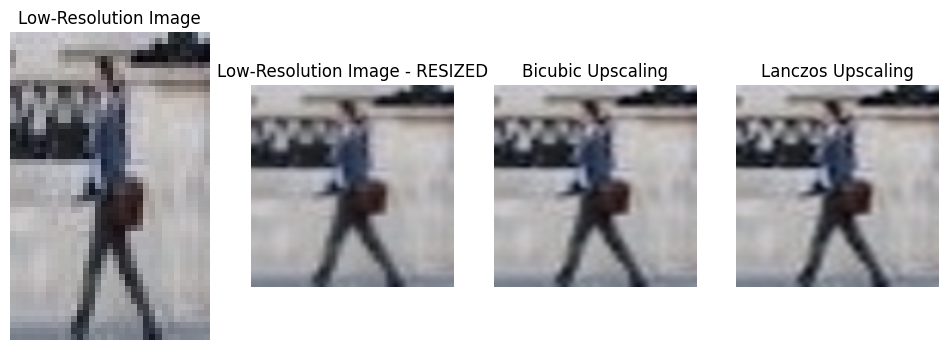

In [20]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image

# Define your dataset path (CHANGE THIS)
dataset_path = "./DATASETS/MMU DATASET CROPPED FULL2"  # Replace with your actual dataset path

# Load dataset (Assuming ImageFolder format)
dataset = ImageFolder(root=dataset_path, transform=transforms.ToTensor()) 

# Get one low-resolution image from the dataset
low_res_image, label = dataset[2]  # Load the first image

# Convert tensor to PIL image for visualization and saving
low_res_image = transforms.ToPILImage()(low_res_image)

# Define upscaling transforms (BICUBIC & LANCZOS)
resize_bicubic = transforms.Resize((299, 299), interpolation=Image.Resampling.BICUBIC)
resize_lanczos = transforms.Resize((299, 299), interpolation=Image.Resampling.LANCZOS)
resized = transforms.Resize((299, 299))
# Apply transformations
bicubic_image = resize_bicubic(low_res_image)
lanczos_image = resize_lanczos(low_res_image)
resized = resized(low_res_image)

# Save the images
low_res_image.save("low_res_image.png")
bicubic_image.save("bicubic_upscaled.png")
lanczos_image.save("lanczos_upscaled.png")
resized.save("resized.png")

print("Images saved successfully!")

# Show Low-Res, Bicubic, and Lanczos images side by side
plt.figure(figsize=(12, 4))

# Low-Resolution Image
plt.subplot(1, 4, 1)
plt.imshow(low_res_image)
plt.title("Low-Resolution Image")
plt.axis("off")

# Low-Resolution Image
plt.subplot(1, 4, 2)
plt.imshow(resized)
plt.title("Low-Resolution Image - RESIZED")
plt.axis("off")

# Upscaled using Bicubic
plt.subplot(1, 4, 3)
plt.imshow(bicubic_image)
plt.title("Bicubic Upscaling")
plt.axis("off")

# Upscaled using Lanczos
plt.subplot(1, 4, 4)
plt.imshow(lanczos_image)
plt.title("Lanczos Upscaling")
plt.axis("off")

plt.show()
